# Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [9]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, maximum, minimum
from numpy import asarray, add, subtract
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from numpy.polynomial.chebyshev import chebpts1

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[1]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011). The projection operator is based on the one presented in Mai et al (2021).
    
    
* Bằng Công Vũ (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators</i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
    
* Vien V. Mai, Jacob Lindbäck, Mikael Johansson. (2021). <i>A Fast and Accurate Splitting Method for Optimal Transport: Analysis and Implementation</i>. arXiV preprint. [https://doi.org/10.48550/arXiv.2110.11738](https://doi.org/10.48550/arXiv.2110.11738).
</div>

Let $\mathcal{X}$ be the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

In the framework of Problem 4.1 from (Vũ, 2011), we will identify $\hat m = 1$, $ \mathcal{H} = \mathcal{G} = \mathbb{R}^{M\times N}$, $z = 0$, $\omega = 1$, $r = 0$, $L = \mathrm{I}_{M\times N}$. Moreover, we identify $f  = \imath_{\mathbb{R}_{\geq 0}}$, $\ell  = \imath_{ \{0\} }$, $g = \imath_{\mathcal{X}}$, and $h$ as the doble contraction product with $c$.

In this context, we have that $h(x) =c:x $ is $\infty$-Lipschitz differentiable, and $g \square \ell = g$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Bằng Công Vũ's Algorithm</h2>
<ol>
<li>Set $\tau, \sigma \in \mathbb{R}_+$ such that $\tau \sigma < 1$
<li>Set $\rho \in (0,2)$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$p_k = \mathrm{prox}_{\tau f} \big( x_k - \tau ( \nabla h(x_k) + y_k ) \big)$
<li>$u_k = 2 p_k - x_k$
<div style="color: #088A68;">
// Dual step //
</div>
<li>$q_k = \mathrm{prox}_{\sigma g^*} ( y_k + \sigma u_k) = ( y_k + \sigma u_k) - \sigma\, \mathrm{prox}_{g}( \sigma^{-1} y_k + u_k)$
<div style="color: #088A68;">
// Inertia step //
</div>
<li>$x_{k+1} = \rho p_k + (1-\rho) x_k$
<li>$y_{k+1} = \rho q_k + (1-\rho) y_k$
</div>

Now, the proximal of $g$ is the projection on $\mathcal{X}$, which is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is known. 

As a result
\begin{align}
    q_k &= (y_k + \sigma u_k) - \sigma \big(\sigma^{-1}y_k + u_k - G(\sigma^{-1} y_k + u_k)\big)
    \\
    &= (y_k + \sigma u_k) - (y_k + \sigma u_k) + \sigma G(\sigma^{-1} y_k + u_k)\big)
    \\
    &= \sigma G(\sigma^{-1} y_k + u_k)\big)
\end{align}
Another way to see this is by instead defining $u_k = \sigma^{-1} y_k + 2p_k - x_k$. Here it is straightfoward that
\begin{align}
    q_k &= \mathrm{prox}_{\sigma g^*} ( \sigma u_k ) = \sigma u_k - \sigma \mathrm{prox}_{g} ( u_k) = \sigma G(u_k).
\end{align}
This gives rise to the following adapted algorithm:

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Bằng Công Vũ's Algorithm for OT</h2>
<ol>
<li>Set $\tau, \sigma \in \mathbb{R}_+$ such that $\tau \sigma < 1$
<li>Set $\rho \in (0,2)$</li>
<li>For $k \in \{1,\ldots, K\}$, do
<ol>
<li>$p_k = [x_k - \tau (c + y_k)]_+$
<li>$u_k = \sigma^{-1} y_k + 2 p_k - x_k$
<div style="color: #088A68;">
// Projection onto the set of real-valued matrices with prescribed row and column sums //
</div>
<li>$\kappa_1 = u_k\mathbb{1}_{N} - m$
<li>$\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$
<li>$\kappa_2 = \mathbb{1}_{M}u_k - n$
<li>$\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$
<li>$q_k = \sigma \big( \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top \big) $
<div style="color: #088A68;">
// Inertia step //
</div>
<li>$x_{k+1} = \rho p_k + (1-\rho) x_k$
<li>$y_{k+1} = \rho q_k + (1-\rho) y_k$
</div>

In [7]:
def primal_dual_improved(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False,
                         τ = 1e-3 * 1.9, σ = 1.0/(1e-3 * 1.9) - 1e-5, ρ = 1.9):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    # Initialise τ
    #τ = 1e-3 * 1.9
    
    # Initialise σ
    #σ = 1.0/τ - 1e-5
    
    # Initialise ρ
    #ρ = 1.9 #- 1e-4 # this helped in 8x8 but not for bigger colour instances
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size

    if show:
        print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    elif guess_y is not None:
        ψ, ϕ = y.copy()
    else:
        x = zeros((M,N));
        ϕ = zeros(M);
        ψ = zeros(N);
        
    #Initialise p, y, u, κ
    κₘ, yₘ = zeros((2,M))
    κₙ, yₙ = zeros((2,N))
    p, u = ones((2,M,N));
    
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Primal Dual scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    for k in range(iters):
        it_time = time.time()
        
        # ** Primal step ** #
        # p = x - τ * (c + y)
        add(c,ψ, out=p);    add(p,ϕ.reshape(M,1), out=p);    subtract(x, τ*p, out=p)
        # [p]_+
        maximum(p, 0.0, p)

        # ** Dual step ** #
        # u = y/σ + 2.0*xₖ - x
        subtract(2.0*p, x, out=u);    add(u,ψ/σ, out=u);    add(u,ϕ.reshape(M,1)/σ, out=u)

        # Projection step
        κₘ = u.sum(1) - m
        κₙ = u.sum(0) - n

        βₘ = κₘ.sum() / (M + N)        # dim M
        βₙ = κₙ.sum() / (M + N)        # dim N

        # Implicit yₖ = ( (κₘ - βₘ)*σ/N).reshape(M,1) + σ*(κₙ - βₙ)/M
        yₘ = (ρ*σ/N) * (κₘ - βₘ)
        yₙ = (ρ*σ/M) * (κₙ - βₙ)

        # ** Inertia ** #
        x *= 1-ρ;   p *= ρ;     x += p
        ϕ *= 1-ρ;   ϕ += yₘ
        ψ *= 1-ρ;   ψ += yₙ
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
                
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    y = asarray([ψ, ϕ],dtype='object')
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [10]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, 
                                                             true_obj = obj_exact, true_obj_tol = 1e-7, 
                                                             true_solution = sol, save_iter = True, show = True)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      4 |   1.0e+00 |  5.6e-01  |     0.00 s |   0.8888 |  1.1784
*      6 |   1.0e-01 |  5.9e-02  |     0.00 s |   0.8619 |  1.0856
*    327 |   1.0e-02 |  9.8e-03  |     0.03 s |   0.3478 |  0.9997
*    445 |   1.0e-03 |  9.1e-04  |     0.03 s |   0.3268 |  1.0005
*    723 |   1.0e-04 |  6.3e-05  |     0.05 s |   0.3111 |  0.9999
*    724 |   1.0e-05 |  4.7e-06  |     0.05 s |   0.3111 |  0.9999
*   1203 |   1.0e-06 |  6.7e-07  |     0.07 s |   0.3110 |  1.0000
*   1241 |   1.0e-07 |  2.6e-08  |     0.08 s |   0.3110 |  1.0001
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0768 seconds and 1241 iterations


In [12]:
print('Average time per iteration:',every_iter['time'][-1]/len(every_iter['time']))

Average time per iteration: 5.830538272857666e-05


We want to perform a series of tests for different values of $\tau$, $\sigma$, and $\rho$. These belong to the following parameter set
\begin{align}
    \Theta := \big\{ (\tau,\sigma,\rho):\, \tau \sigma < 1, \tau>0, \sigma > 0, \,\,\text{ and }\,\, \rho \in (0,2) \big\}.
\end{align}
We observe that $\Theta$ is just the cross product between the positive points under the curve $(\cdot)^{-1}$ (let us denote this set as $\Theta_1$) and an open interval ($\Theta_2$). As a result, to numerically study the effects of these parameters, we will create a mesh for both sets. In this setting $\Theta_2$ will have a standard equispaced discretisation of $\ell_\rho \in \mathbb{N}$ points:
\begin{align}
    \Theta_2 \approx \big\{ {2k} \big/{(\ell_\rho+1)}:\, k \in [ 1,\ell_\rho ]  \big\}
\end{align}
or a spectral grid considering that values close to the endpoints of the interval often result in good results for the algorithm:
\begin{align}
    \Theta_2 \approx \big\{ 1 + \cos \big( \pi {(2k + 1)} \big/ {2\ell_\rho} \big) :\, k \in [ 0,\ell_\rho-1 ]  \big\}.
\end{align}

In contrast, for $\Theta_1$ we will consider a discretisation given by equispaced points in $\tau$ and their functional transformation by a family of hyperbolas in the form $r_c(\tau) = c \tau^{-1}$, which are "equispaced" along the line segment between $(0,0)$ and $(1,1)$. Namely, let $M>0$, $\ell_\tau, \ell_\sigma \in \mathbb{N}$, and
\begin{align}
    T &:= \big\{ {Mk} \big/{\ell_\tau}:\, k \in [ 1,\ell_\tau] \big\},
    \\
    E &:= \big\{ {k} \big/{(\ell_\sigma+1)}:\, k \in [ 1,\ell_\sigma] \big\}.
\end{align}
Using this, the familiy of hyperbolas we will use is completely described by $c = e^2$ with $e \in E$. Then every choice of $\sigma$ will be given by the image of $r_c(\tau)$ for all $\tau \in T$. This can be described as
\begin{align}
    \Theta_1 \approx \big\{ (\tau,\sigma):\, \tau \in T\,\,\text{ and } \,\, \sigma = e^2 \tau^{-1} \, \forall e\in E \big\}.
\end{align}

However, this might result in few large values of $\sigma$ but large values of $\tau$ will be considered. As an alternative, we can symmetrice the points in $\Theta_1$ with respect to the identity function.

In [16]:
ℓ_ρ = 30
ℓ_τ = 50
ℓ_σ = 12    # Not many needed
M = 100     # Plot below done with 5

Θ_2 = chebpts1(ℓ_ρ) + 1            #linspace(0,2,ℓ_ρ+2)[1:-1]
T   = linspace(0,M,ℓ_τ+1)[1:]
E   = linspace(0,1,ℓ_σ+2)[1:-1]

In [17]:
A = ((E**2)[..., np.newaxis] * T**-1)
Aᵢ = where(A<T,A,np.nan).T

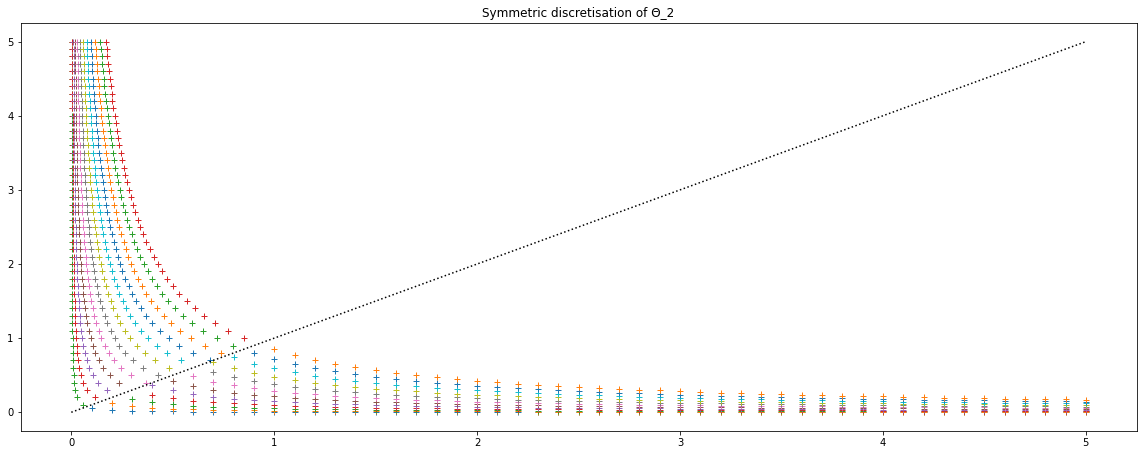

In [15]:
# Visualise discretisation
plt.figure(figsize = (20,7.5))

#plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);
plt.title('Symmetric discretisation of Θ_2')
plt.plot(T,Aᵢ,'+')
plt.plot(Aᵢ,T,'+')
plt.plot([0,5],[0,5],':',c='black')

plt.show()

In [18]:
DAᵢ = {T[t]: Aᵢ[t][~np.isnan(Aᵢ[t])].tolist() for t in range(T.size)}

In [19]:
DSᵢ = {(a,c) for a,b in DAᵢ.items() for c in b if len(b)>0}
DSⱼ = {(b,a) for (a,b) in DSᵢ}
DSₖ = {(a,a) for a in A[A==T].tolist()}

In [20]:
Θ_1 = DSᵢ | DSⱼ | DSₖ

We are additionally interested in testing what happens when we scale $c$ by a parameter $\gamma$. For this we will consider the numerical range $\gamma \in [10^{-3},2]$. As there is no direct knowledge on the effect of this scaling, we will consider an uniform grid added the point $\gamma=1$ for comparison.

In [32]:
ℓ_γ = 32
Θ_3 = linspace(1e-3,6.0,ℓ_γ-1)
Θ_3 = asarray(sorted(Θ_3.tolist() + [1.0]))

In [66]:
it = 0
Collector = []
# For each triplet, store #iterations, smallest objective distance, time spent
Start = time.time()
for τ,σ in iter(Θ_1):
    for ρ in Θ_2:
        for γ in Θ_3:
            _, _, _, _, every_iter = primal_dual_improved(γ*(c+1.0), m,n, 1250, collect_obj = True, 
                                                        true_obj = γ*o(bj_exact+1.0), true_obj_tol = 1e-7, 
                                                   true_solution = sol, save_iter = True, τ=τ,σ=σ, ρ=ρ)
            Collector.append( [τ,σ,ρ,γ,every_iter['it'][-1], 
                               asarray(every_iter['dist_obj']).min(), every_iter['time'][-1]] )
        
    it +=1
    if it % 5 == 0:
        print('({0:.3f}, {1:.3f})'.format(τ,σ))
        #break
End = time.time()
print('–––––––––––\n\nTime spent: {0:.3f}'.format( abs(End-Start) ))

(48.000, 0.018)
(0.001, 90.000)
(0.000, 22.000)
(0.009, 92.000)
(12.000, 0.004)
(0.017, 50.000)
(0.001, 22.000)
(0.011, 54.000)
(24.000, 0.000)
(0.004, 56.000)
(0.010, 28.000)
(76.000, 0.006)
(4.000, 0.024)
(10.000, 0.002)
(0.003, 56.000)
(0.030, 20.000)
(0.008, 26.000)
(84.000, 0.000)
(0.017, 28.000)
(52.000, 0.004)
(0.000, 48.000)
(0.010, 48.000)
(14.000, 0.002)
(24.000, 0.025)
(0.002, 78.000)
(22.000, 0.013)
(6.000, 0.119)
(0.000, 80.000)
(44.000, 0.007)
(0.002, 86.000)
(26.000, 0.006)
(0.007, 68.000)
(20.000, 0.019)
(42.000, 0.000)
(4.000, 0.213)
(0.012, 32.000)
(92.000, 0.009)
(0.001, 28.000)
(64.000, 0.013)
(26.000, 0.001)
(60.000, 0.010)
(64.000, 0.007)
(90.000, 0.004)
(0.022, 22.000)
(6.000, 0.016)
(0.061, 14.000)
(0.034, 14.000)
(38.000, 0.004)
(0.021, 34.000)
(0.038, 10.000)
(38.000, 0.022)
(0.000, 76.000)
(60.000, 0.000)
(0.007, 52.000)
(0.005, 30.000)
(66.000, 0.006)
(22.000, 0.027)
(0.000, 68.000)
(0.027, 8.000)
(0.001, 82.000)
(0.008, 46.000)
(86.000, 0.002)
(74.000, 0.00

In [67]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved'

In [71]:
df_collected = pd.DataFrame(Collector)
df_collected.columns = ['τ','σ','ρ','γ','its','dist_obj','time']
#df_collected.to_csv(out_folder+'Critical_(τ,σ,ρ,γ).csv')
df_collected.to_csv(out_folder+'Critical_(τ,σ,ρ,γ).csv.gz',compression='gzip')

In [70]:
df_collected.describe()

,τ,σ,ρ,γ,its,dist_obj,time
count,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06
mean,2.550721e+01,2.550721e+01,1.000000e+00,1.000483e+00,1.248904e+03,5.562842e-01,7.265007e-02
std,3.265553e+01,3.265553e+01,7.071071e-01,5.872761e-01,8.135885e+00,4.680791e-01,2.088933e+00
min,5.917160e-05,5.917160e-05,1.370465e-03,1.000000e-03,1.200000e+01,1.306457e-09,7.393360e-04
25%,5.437351e-03,5.437351e-03,2.928932e-01,5.007500e-01,1.249000e+03,1.210390e-02,6.951284e-02
50%,1.213018e+00,1.213018e+00,1.000000e+00,1.000250e+00,1.249000e+03,9.362696e-01,6.980181e-02
75%,5.050000e+01,5.050000e+01,1.707107e+00,1.500250e+00,1.249000e+03,1.000000e+00,7.062149e-02
max,1.000000e+02,1.000000e+02,1.998630e+00,2.000000e+00,1.249000e+03,1.000000e+00,2.087963e+03


---